In [1]:
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sounddevice as sd
import torchaudio as ta
import torch
from nnAudio import Spectrogram
from mlp64.st import *
sd.default.samplerate = 16000

In [2]:
pathns = Path("../dataset/nsynth-valid/audio/")
clip, sr = librosa.load(pathns / "bass_electronic_018-041-025.wav", sr=16000)
pathbirds = Path("../baselines/birds.wav")
path = Path("../baselines/church_bells.wav")
pathout = Path("../experiments/RI_own/out.wav")
clip, sr = librosa.load(path, sr=16000)
out, _ = librosa.load(pathout, sr=16000)
sd.play(clip, sr)

/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


FileNotFoundError: [Errno 2] No such file or directory: '../baselines/church_bells.wav'

/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/nnAudio/Spectrogram.py:281: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


CQT kernels created, time used = 1.7144 seconds
CQT kernels created, time used = 0.0246 seconds
STFT kernels created, time used = 0.0242 seconds
STFT kernels created, time used = 0.0244 seconds
STFT kernels created, time used = 0.0248 seconds
torch.Size([1, 513, 1001])


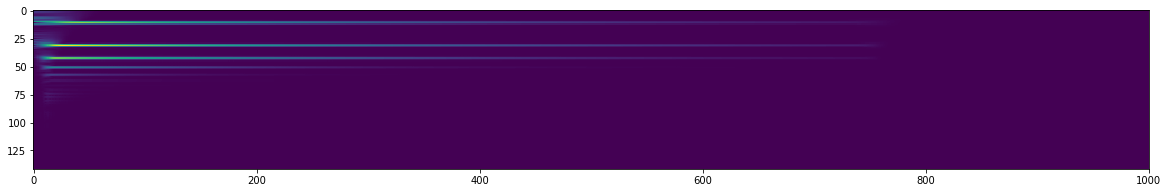

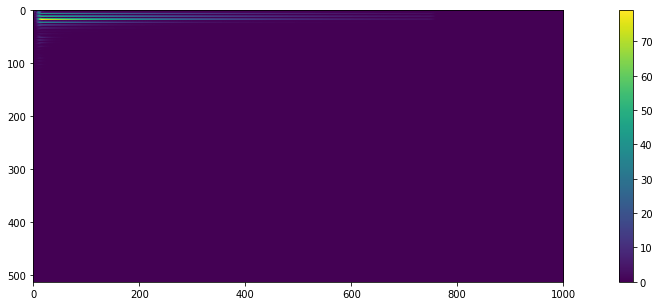

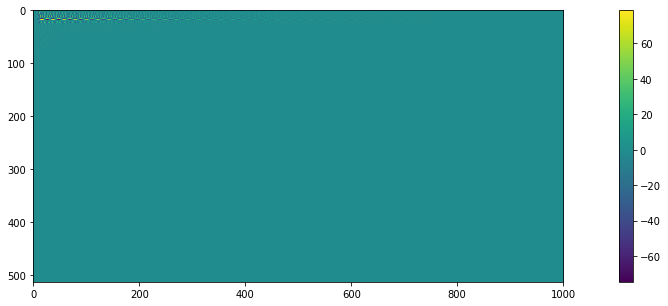

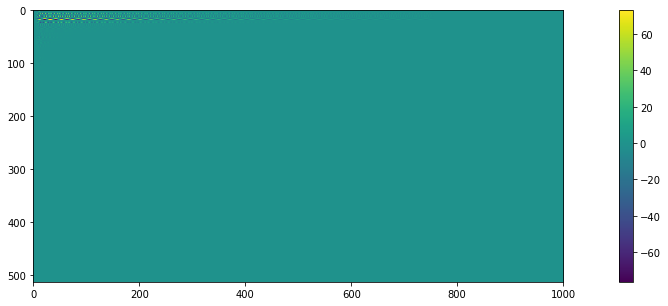

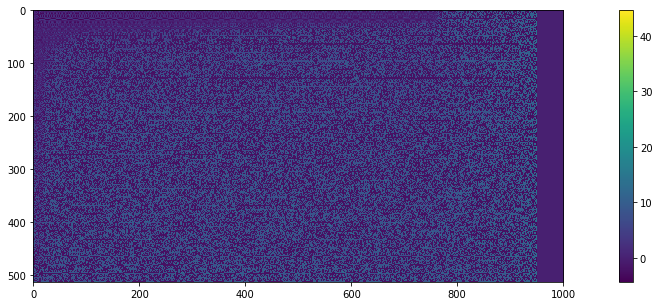

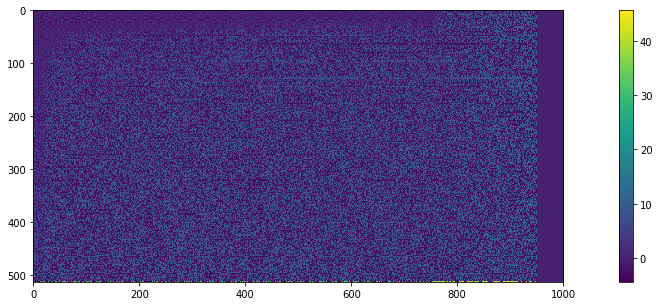

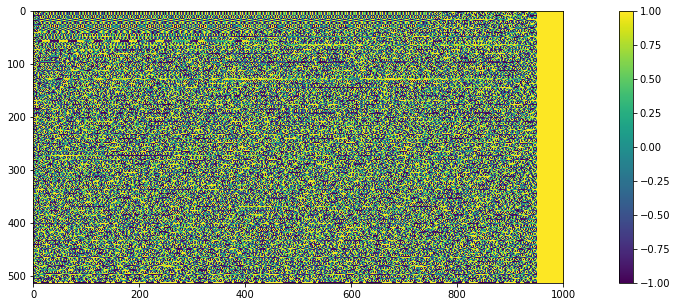

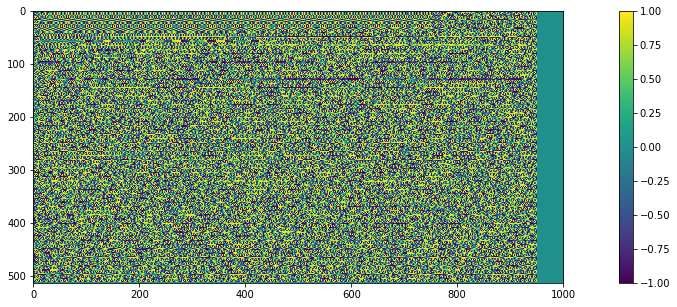

In [3]:
spec = Spectrogram.CQT(sr=16000, hop_length=64, fmin=60, fmax=8192, bins_per_octave=20,
                                      norm=1, window='hann', center=True, pad_mode='reflect')
cqt = Spectrogram.CQT1992v2(sr=16000, hop_length=512, fmin=32.7, n_bins=84, bins_per_octave=12,
                            norm=1, window='hann', center=True, pad_mode='reflect', trainable=False)

spec_mag = Spectrogram.STFT(sr=16000, n_fft=1024, freq_bins=None, hop_length=64, output_format="Magnitude")

spec_c = Spectrogram.STFT(sr=16000, n_fft=1024, freq_bins=None, hop_length=64, output_format="Complex")

spec_p = Spectrogram.STFT(sr=16000, n_fft=1024, freq_bins=None, hop_length=64, output_format="Phase")

test = torch.from_numpy(clip).cuda()
s = spec(test)
s2 = spec_mag(test)
s3 = spec_c(test)
s5 = spec_p(test)
print(s2.shape)

plt.figure(figsize=(20, 10))
plt.imshow(s.squeeze().cpu())
plt.figure(figsize=(20, 5))
plt.imshow(s2.squeeze().cpu()); plt.colorbar()
plt.figure(figsize=(20, 5))
plt.imshow(s3.squeeze().cpu()[:, :, 0]); plt.colorbar()
plt.figure(figsize=(20, 5))
plt.imshow(s3.squeeze().cpu()[:, :, 1]); plt.colorbar()
def norm01(x):
    return (x - x.min()) / (x.max() - x.min())

def prep(x):
    x[x > 0] = torch.log(x[x > 0])
    x[x < 0] = - torch.log(-x[x < 0])
    return x
#s4 = torch.log(norm01(s3))
s4 = prep(s3)

plt.figure(figsize=(20, 5))
plt.imshow(s4.squeeze().cpu()[:, :, 0]); plt.colorbar()
plt.figure(figsize=(20, 5))
plt.imshow(s4.squeeze().cpu()[:, :, 1]); plt.colorbar()

plt.figure(figsize=(20, 5))
plt.imshow(s5.squeeze().cpu()[:, :, 0]); plt.colorbar()
plt.figure(figsize=(20, 5))
plt.imshow(s5.squeeze().cpu()[:, :, 1]); plt.colorbar()



STFT kernels created, time used = 0.0149 seconds


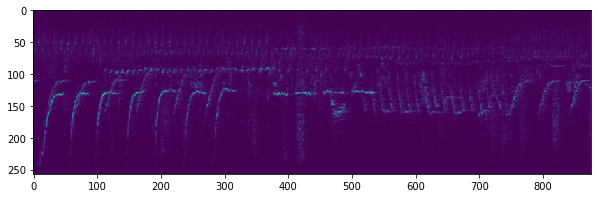

In [11]:
spec_mag = Spectrogram.STFT(sr=16000, n_fft=512, freq_bins=None, hop_length=128, output_format="Magnitude")

clip, sr = librosa.load(pathbirds, sr=16000)
test = torch.from_numpy(clip).cuda()
s = spec_mag(test)
plt.figure(figsize=(10, 10))
plt.imshow(s.squeeze().cpu())

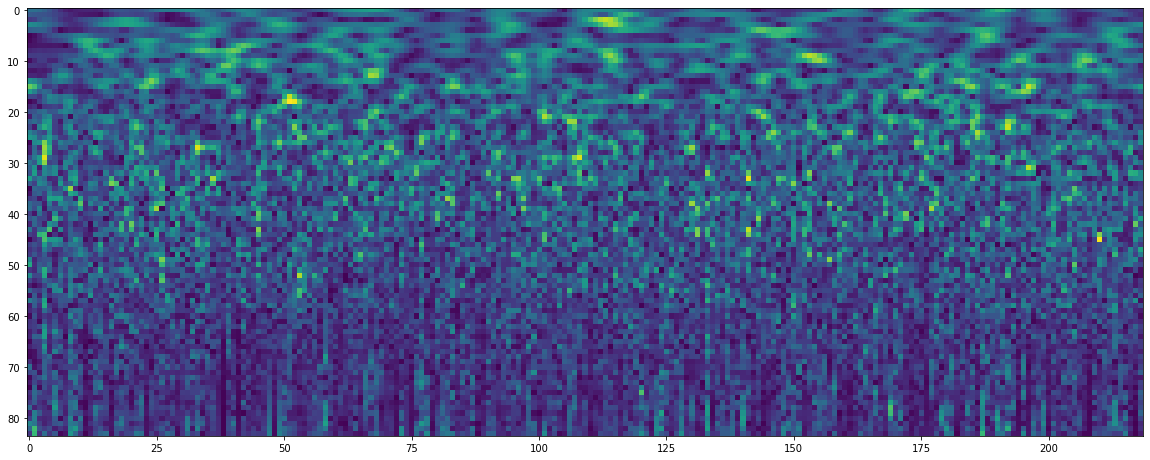

In [35]:
#out = torch.from_numpy(out).cuda()
cqts = cqt(out)
plt.figure(figsize=(20, 10))
plt.imshow(cqts.detach().cpu().squeeze())

In [33]:
out

tensor([ 0.4954, -0.5557,  1.0000,  ...,  0.4232,  1.0000,  1.0000],
       device='cuda:0')

In [5]:
?Spectrogram.CQT1992v2

Init signature:
Spectrogram.CQT1992v2(
    sr=22050,
    hop_length=512,
    fmin=32.7,
    fmax=None,
    n_bins=84,
    bins_per_octave=12,
    norm=1,
    window='hann',
    center=True,
    pad_mode='reflect',
    trainable=False,
    output_format='Magnitude',
    verbose=True,
    device='cuda:0',
)
Docstring:     
This function is to calculate the CQT of the input signal. Input signal should be in either of the following shapes. 1. ``(len_audio)``, 2. ``(num_audio, len_audio)``, 3. ``(num_audio, 1, len_audio)``. The correct shape will be inferred autommatically if the input follows these 3 shapes. Most of the arguments follow the convention from librosa. This class inherits from ``torch.nn.Module``, therefore, the usage is same as ``torch.nn.Module``.

This alogrithm uses the method proposed in [1]. I slightly modify it so that it runs faster than the original 1992 algorithm, that is why I call it version 2. 
[1] Brown, Judith C.C. and Miller Puckette. “An efficient algorithm fo

In [164]:
def ri_spec(x: torch.Tensor, n_fft, hop_length, window):
    # Make sure to be in logarithmic scale
    x = torch.stft(x, n_fft, hop_length, window=window)
    x = (2 * torch.sigmoid(x)) - 1
    return x.transpose(2, 0).transpose(1, 2)[None, :]

def ri_spec2(x: torch.Tensor, n_fft, hop_length, window):
    # Make sure to be in logarithmic scale
    x = torch.stft(x, n_fft, hop_length, window=window)
    x = (2 * torch.sigmoid(x)) - 1
    return x.permute(2, 0, 1)[None, :]

In [138]:
window = torch.hann_window(512).cuda()

In [147]:
torch.stft(test, 512, 128, window=window).shape

torch.Size([257, 876, 2])

In [166]:
%%timeit
ri_spec(test, 512, 128, window)

110 µs ± 362 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [165]:
%%timeit
ri_spec2(test, 512, 128, window)

108 µs ± 927 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [157]:
a = ri_spec2(test, 512, 128, window)

In [162]:
a

torch.Size([2, 257, 876])

In [60]:
def log_mel_spec_tfm(x, sample_rate, n_fft = 16000):
    
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    plt.imshow(mel_spec_db, origin='lower')
    return mel_spec_db

(40, 251)

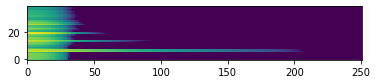

In [61]:
log_mel_spec_tfm(data[:, 1], sr).shape

(40, 251)

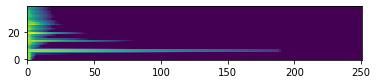

In [62]:
log_mel_spec_tfm(data[:, 1], sr, n_fft=1024).shape

In [45]:
data = np.empty((64000, len(list(path.iterdir()))), dtype=np.float32, order="F")

In [46]:
for i, p in enumerate(path.iterdir()):
    data[:, i], _ = librosa.load(p, sr=16000)

In [ ]:
for i in data.T:
    sd.play(i)
    sd.wait()

In [9]:
sr = 16000
hop_length = 128
bpo = 60
n_bins = 400
c = np.abs(librosa.cqt(npdata[:, 1], sr=sr, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bpo))
print(c.shape)
ic = librosa.icqt(c, sr=sr, hop_length=hop_length, bins_per_octave=bpo)
print(ic.shape)
Audio(ic, rate=16000)

(400, 501)
(64000,)


In [10]:
hop_length = 160
n_fft = 512
c = librosa.feature.melspectrogram(npdata[:, 1], sr=sr, n_fft=n_fft, hop_length=hop_length)
print(c.shape)
ic = librosa.feature.inverse.mel_to_audio(c, sr=sr, n_fft=n_fft, hop_length=hop_length)
print(ic.shape)
sd.play(ic)

(128, 401)
(64000,)


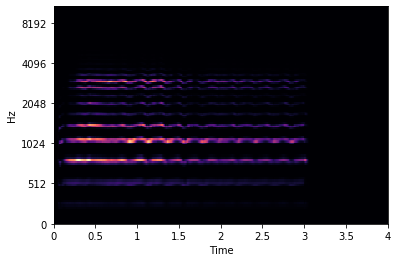

In [11]:
librosa.display.specshow(c, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');

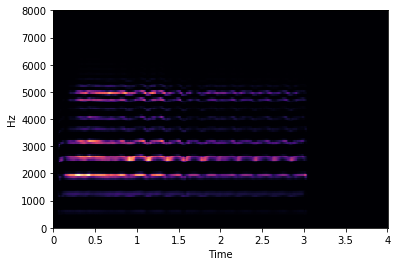

In [12]:
librosa.display.specshow(c, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='linear');

In [586]:
hop_length = 160
n_fft = 800
c = librosa.stft(npdata[:, 1], n_fft=n_fft, hop_length=hop_length)
print(c.shape, np.prod(c.shape))
ic = librosa.istft(c, hop_length=hop_length)
print(ic.shape)
sd.play(ic)

(401, 401) 160801
(64000,)
